In [55]:
import os
import time
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, utils
#from torchsummary import summary

from PIL import Image

In [ ]:
writer = SummaryWriter('runs/fashion-mnist-1')

## 1. Load CSV files

The csv files can be download from [this link](https://www.kaggle.com/zalando-research/fashionmnist)

In [12]:
data_path = os.path.join("data", "fashion-mnist")
train_path = os.path.join(data_path, "fashion-mnist_train.csv")
test_path = os.path.join(data_path, "fashion-mnist_test.csv")
print(train_path, test_path)

data/fashion-mnist/fashion-mnist_train.csv data/fashion-mnist/fashion-mnist_test.csv


In [13]:
train_df = pd.read_csv(train_path)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
test_df = pd.read_csv(test_path)
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print(train_df.shape, test_df.shape)
print(train_df.info())
print(test_df.info())

(60000, 785) (10000, 785)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB
None


In [6]:
train_df.iloc[0, 1:].max()

255

In [7]:
train_df['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [8]:
test_df['label'].value_counts()

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
Name: label, dtype: int64

## 2. Format into images

Loading all the data in the CSV file is not memory efficient. Also, We cannot understand the data in raw format. Hence, I am going to format this file into images in the following format.
* train/0/xxx.png
* train/1/xxx.png
* train/2/xx.png
* ...

In [9]:
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")
print(train_path, test_path)

data/fashion-mnist/train data/fashion-mnist/test


In [10]:
for path in [train_path, test_path]:
    if not os.path.exists(path):
        os.mkdir(path)

In [11]:
class_labels = train_df['label'].unique().tolist()
print(class_labels)

[2, 9, 6, 0, 3, 4, 5, 8, 7, 1]


In [12]:
for path in [train_path, test_path]:
    for class_label in class_labels:
        class_path = os.path.join(path, str(class_label))
        if not os.path.exists(class_path):
            os.mkdir(class_path)

In [13]:
for row_id, row in tqdm_notebook(train_df.iterrows(), total=len(train_df)):
    label = row['label']
    image_path = os.path.join(data_path, "train", str(label), "{}.png".format(row_id))
    pixels = row.iloc[1:].values.astype("uint8")
    pixels = pixels.reshape(28, 28)
    image = Image.fromarray(pixels)
    image.save(image_path)

In [14]:
for row_id, row in tqdm_notebook(test_df.iterrows(), total=len(test_df)):
    label = row['label']
    image_path = os.path.join(data_path, "test", str(label), "{}.png".format(row_id))
    pixels = row.iloc[1:].values.astype("uint8")
    pixels = pixels.reshape(28, 28)
    image = Image.fromarray(pixels)
    image.save(image_path)

**Note**: `del dataframe` does not release memory. So restart the notebook and start executimg from the next section after generating images.

## 3. Define dataset

In [2]:
data_path = os.path.join("data", "fashion-mnist")
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")
print(train_path, test_path)

data/fashion-mnist/train data/fashion-mnist/test


`torchvision.transforms.ToTensor()` squishes the value range from [0, 255] to [0., 1.]

In [20]:
mean = 0.5
sd = 0.5
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((mean, ), (sd, ))
])

We can use `torchvision.datasets.ImageFolder()` to define the dataset instead of writing a dataset class from scratch.

In [26]:
train_set = datasets.ImageFolder(root=train_path, transform=transform)
test_set = datasets.ImageFolder(root=test_path, transform=transform)

## 4. Define dataloader

In [27]:
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4) 
test_loader = DataLoader(test_set, batch_size=4, shuffle=False, num_workers=4)

## 5. Define utilities

In [28]:
label_to_name = {
    "0": "t-shirt",
    "1": "trouser",
    "2": "pullover",
    "3": "dress",
    "4": "coat",
    "5": "sandal", 
    "6": "shirt",
    "7": "sneaker",
    "8": "bag",
    "9": "ankle_boot"
}

In [29]:
name_to_label = {v: k for k, v in label_to_name.items()}
print(name_to_label)

{'t-shirt': '0', 'trouser': '1', 'pullover': '2', 'dress': '3', 'coat': '4', 'sandal': '5', 'shirt': '6', 'sneaker': '7', 'bag': '8', 'ankle_boot': '9'}


In [43]:
def plot_image(image_tensor, title=""):
    """
    Arguments:
    image_tensor -- tensor of Size([1, n_h, n_w]) / Size([3, n_h+4, n_w*m+4])
    """
    # image_tensor.squeeze() -> doesn't work for grids of Size([3, n_h+4, n_c*m+4])
    image_tensor = image_tensor.mean(dim = 0) # Size([28, 28])
    image_tensor = (image_tensor * sd) + mean
    image_tensor = image_tensor * 255 # not necessary
    image_array = image_tensor.numpy()
    plt.imshow(image_array, cmap='Greys')
    plt.title(title)
    return plt.show()

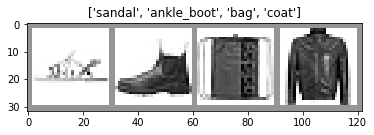

In [45]:
train_iter = iter(train_loader)
X, Y = train_iter.next()
image_grid = utils.make_grid(X)
names = [label_to_name[str(label.item())] for label in Y]
plot_image(image_grid, title=names)

## 6. Define model

The following architecture is modified from the LeNet

In [48]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0) # [m, 6, 24, 24]
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # [m, 6, 12, 12]
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0) # [m, 16, 8, 8]
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # [m, 16, 4, 4]
        self.fc3 = nn.Linear(in_features=16*4*4, out_features=120) # [m, 120]
        self.fc4 = nn.Linear(in_features=120, out_features=84) # [m, 84]
        self.fc5 = nn.Linear(in_features=84, out_features=10) # [m, 10]
        
    def forward(self, X):
        X = self.pool1(F.relu(self.conv1(X)))
        X = self.pool2(F.relu(self.conv2(X)))
        X = X.view(-1, 16*4*4)
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = self.fc5(X) 
        return X

In [51]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc3): Linear(in_features=256, out_features=120, bias=True)
  (fc4): Linear(in_features=120, out_features=84, bias=True)
  (fc5): Linear(in_features=84, out_features=10, bias=True)
)


In [52]:
#summary(net, (1, 28, 28))

In [ ]:
writer.add_graph(net, X)
writer.close()

**Note:** Use `tensorboard --logdir=runs` command in the Terminal to view the TensorBoard